In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 29.6 MB/s eta 0:00:00


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="ZhKWCwI8rz9309wg03nk")
project = rf.workspace("andrea-marazzina").project("construction-ppe-rdhzo-fnopv")
version = project.version(1)
dataset = version.download("yolov8")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 80.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.13.0.90
    Uninstalling opencv-python-headless-4.13.0.90:
      Successfully uninstalled opencv-python-headless-4.13.0.90
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Construction-PPE-1 in yolov8:: 100%|██████████| 17702/17702 [00:08<00:00, 2086.73it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
!ls

Construction-PPE-1  sample_data


In [ ]:
import yaml, pprint

with open("Construction-PPE-1/data.yaml", "r") as f:
    data = yaml.safe_load(f)

pprint.pprint(data)
print("\nClass names:")
for i, n in enumerate(data.get("names", [])):
    print(i, n)


{'names': ['Gloves',
           'Helmet',
           'Human',
           'Safety Boot',
           'Safety Vest',
           'boots',
           'glasses',
           'gloves',
           'hat',
           'helmet',
           'no boot',
           'no boots',
           'no gloves',
           'no hat',
           'no vest',
           'vest'],
 'nc': 16,
 'roboflow': {'license': 'CC BY 4.0',
              'project': 'construction-ppe-rdhzo-fnopv',
              'url': 'https://universe.roboflow.com/andrea-marazzina/construction-ppe-rdhzo-fnopv/dataset/1',
              'version': 1,
              'workspace': 'andrea-marazzina'},
 'test': '../test/images',
 'train': '../train/images',
 'val': '../valid/images'}

Class names:
0 Gloves
1 Helmet
2 Human
3 Safety Boot
4 Safety Vest
5 boots
6 glasses
7 gloves
8 hat
9 helmet
10 no boot
11 no boots
12 no gloves
13 no hat
14 no vest
15 vest


In [ ]:
import os
import shutil
from pathlib import Path

# =========================
# CONFIG
# =========================
src_root = Path("Construction-PPE-1")          # cartella dataset scaricata da Roboflow
dst_root = Path("Construction-PPE-1_DPI3")    # cartella output filtrata

splits = ["train", "valid", "test"]

# MAPPING: classi originali -> nuove classi
# Nuove classi:
# 0 = safety_vest
# 1 = gloves
# 2 = safety_shoes
keep_classes = {
    4: 0,    # Safety Vest
    15: 0,   # vest
    0: 1,    # Gloves
    7: 1,    # gloves
    3: 2,    # Safety Boot
    5: 2     # boots
}

# =========================
# UTILS
# =========================
def find_image_file(img_dir: Path, stem: str):
    """
    Cerca un'immagine con estensioni comuni.
    Ritorna il path se trovato, altrimenti None.
    """
    for ext in [".jpg", ".jpeg", ".png", ".webp"]:
        p = img_dir / f"{stem}{ext}"
        if p.exists():
            return p
    return None

# =========================
# CLEAN OUTPUT FOLDER (se già esiste)
# =========================
if dst_root.exists():
    shutil.rmtree(dst_root)
dst_root.mkdir(parents=True, exist_ok=True)

# =========================
# PROCESS
# =========================
stats = {s: {"kept_images": 0, "kept_labels": 0} for s in splits}

for split in splits:
    src_img_dir = src_root / split / "images"
    src_lbl_dir = src_root / split / "labels"

    dst_img_dir = dst_root / split / "images"
    dst_lbl_dir = dst_root / split / "labels"
    dst_img_dir.mkdir(parents=True, exist_ok=True)
    dst_lbl_dir.mkdir(parents=True, exist_ok=True)

    label_files = list(src_lbl_dir.glob("*.txt"))

    for label_path in label_files:
        stem = label_path.stem  # nome file senza estensione
        new_lines = []

        # Leggi label YOLO: cls x y w h
        with open(label_path, "r") as f:
            lines = f.read().strip().splitlines()

        for line in lines:
            parts = line.strip().split()
            if len(parts) < 5:
                continue

            old_cls = int(float(parts[0]))
            if old_cls in keep_classes:
                new_cls = keep_classes[old_cls]
                parts[0] = str(new_cls)
                new_lines.append(" ".join(parts))

        # Se rimane almeno una bbox utile, copia immagine e salva label filtrata
        if new_lines:
            img_path = find_image_file(src_img_dir, stem)
            if img_path is None:
                # Se manca l'immagine, saltiamo
                continue

            shutil.copy(img_path, dst_img_dir / img_path.name)

            with open(dst_lbl_dir / f"{stem}.txt", "w") as f:
                f.write("\n".join(new_lines))

            stats[split]["kept_images"] += 1
            stats[split]["kept_labels"] += len(new_lines)

print("✅ Dataset DPI3 creato!")
print("📊 Stats:")
for split in splits:
    print(f" - {split}: images={stats[split]['kept_images']}  labels={stats[split]['kept_labels']}")

# =========================
# WRITE data.yaml
# =========================
data_yaml = f"""path: {dst_root}
train: train/images
val: valid/images
test: test/images

names:
  0: safety_vest
  1: gloves
  2: safety_shoes
"""

with open(dst_root / "data.yaml", "w") as f:
    f.write(data_yaml)

print("✅ Creato anche:", dst_root / "data.yaml")

# =========================
# QUICK CHECK
# =========================
print("\nContenuto cartella output:")
print(os.listdir(dst_root))


✅ Dataset DPI3 creato!
📊 Stats:
 - train: images=7016  labels=23445
 - valid: images=784  labels=2801
 - test: images=354  labels=1210
✅ Creato anche: Construction-PPE-1_DPI3/data.yaml

Contenuto cartella output:
['valid', 'data.yaml', 'train', 'test']


In [ ]:
!pip install -q ultralytics

In [ ]:
!cat Construction-PPE-1_DPI3/data.yaml

path: Construction-PPE-1_DPI3
train: train/images
val: valid/images
test: test/images

names:
  0: safety_vest
  1: gloves
  2: safety_shoes


In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

results = model.train(
    data="Construction-PPE-1_DPI3/data.yaml",
    epochs=30,
    imgsz=640,
    batch=16,
    name="DPI3_yolov8n_baseline"
)

Ultralytics 8.4.11 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=Construction-PPE-1_DPI3/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=DPI3_yolov8n_baseline, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patien

KeyboardInterrupt: 

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!nvidia-smi

Wed Feb  4 19:53:36 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install -q ultralytics roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 118.9 MB/s eta 0:00:00


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="ZhKWCwI8rz9309wg03nk")
project = rf.workspace("andrea-marazzina").project("construction-ppe-rdhzo-fnopv")
version = project.version(1)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Construction-PPE-1 in yolov8:: 100%|██████████| 17702/17702 [00:03<00:00, 5370.28it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
!pip install -q ultralytics roboflow

In [ ]:
!pip install -q ultralytics roboflow

In [ ]:
!ls

Construction-PPE-1  sample_data


In [ ]:
import os
import shutil
from pathlib import Path

src_root = Path("Construction-PPE-1")
dst_root = Path("Construction-PPE-1_DPI3")
splits = ["train", "valid", "test"]

# Mapping classi originali -> nuove classi
# 0 safety_vest (4, 15)
# 1 gloves (0, 7)
# 2 safety_shoes (3, 5)
keep_classes = {
    4: 0,    # Safety Vest
    15: 0,   # vest
    0: 1,    # Gloves
    7: 1,    # gloves
    3: 2,    # Safety Boot
    5: 2     # boots
}

def find_image_file(img_dir: Path, stem: str):
    for ext in [".jpg", ".jpeg", ".png", ".webp"]:
        p = img_dir / f"{stem}{ext}"
        if p.exists():
            return p
    return None

# reset cartella output
if dst_root.exists():
    shutil.rmtree(dst_root)
dst_root.mkdir(parents=True, exist_ok=True)

stats = {s: {"kept_images": 0, "kept_labels": 0} for s in splits}

for split in splits:
    src_img_dir = src_root / split / "images"
    src_lbl_dir = src_root / split / "labels"

    dst_img_dir = dst_root / split / "images"
    dst_lbl_dir = dst_root / split / "labels"
    dst_img_dir.mkdir(parents=True, exist_ok=True)
    dst_lbl_dir.mkdir(parents=True, exist_ok=True)

    for label_path in src_lbl_dir.glob("*.txt"):
        stem = label_path.stem
        new_lines = []

        with open(label_path, "r") as f:
            lines = f.read().strip().splitlines()

        for line in lines:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            old_cls = int(float(parts[0]))
            if old_cls in keep_classes:
                parts[0] = str(keep_classes[old_cls])
                new_lines.append(" ".join(parts))

        if new_lines:
            img_path = find_image_file(src_img_dir, stem)
            if img_path is None:
                continue

            shutil.copy(img_path, dst_img_dir / img_path.name)
            with open(dst_lbl_dir / f"{stem}.txt", "w") as f:
                f.write("\n".join(new_lines))

            stats[split]["kept_images"] += 1
            stats[split]["kept_labels"] += len(new_lines)

print("✅ Dataset DPI3 creato!")
for split in splits:
    print(f"- {split}: images={stats[split]['kept_images']} labels={stats[split]['kept_labels']}")

# scrive data.yaml
data_yaml = f"""path: {dst_root}
train: train/images
val: valid/images
test: test/images

names:
  0: safety_vest
  1: gloves
  2: safety_shoes
"""
with open(dst_root / "data.yaml", "w") as f:
    f.write(data_yaml)

print("✅ Creato anche:", dst_root / "data.yaml")

✅ Dataset DPI3 creato!
- train: images=7016 labels=23445
- valid: images=784 labels=2801
- test: images=354 labels=1210
✅ Creato anche: Construction-PPE-1_DPI3/data.yaml


In [ ]:
!ls Construction-PPE-1_DPI3

data.yaml  test  train	valid


In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")
model.train(
    data="Construction-PPE-1_DPI3/data.yaml",
    epochs=20,
    imgsz=640,
    batch=16,
    workers=2,
    name="DPI3_gpu_run"
)

Ultralytics 8.4.11 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=Construction-PPE-1_DPI3/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=DPI3_gpu_run, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, p

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e31fc48a1b0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [ ]:
!ls /content/runs/detect/DPI3_gpu_run

args.yaml			 results.csv	      val_batch0_labels.jpg
BoxF1_curve.png			 results.png	      val_batch0_pred.jpg
BoxP_curve.png			 train_batch0.jpg     val_batch1_labels.jpg
BoxPR_curve.png			 train_batch1.jpg     val_batch1_pred.jpg
BoxR_curve.png			 train_batch2.jpg     val_batch2_labels.jpg
confusion_matrix_normalized.png  train_batch4390.jpg  val_batch2_pred.jpg
confusion_matrix.png		 train_batch4391.jpg  weights
labels.jpg			 train_batch4392.jpg


In [ ]:
!ls /content/runs/detect/DPI3_gpu_run | head

args.yaml
BoxF1_curve.png
BoxP_curve.png
BoxPR_curve.png
BoxR_curve.png
confusion_matrix_normalized.png
confusion_matrix.png
labels.jpg
results.csv
results.png


In [ ]:
from ultralytics import YOLO

model = YOLO("/content/runs/detect/DPI3_gpu_run/weights/best.pt")

model.predict(
    source="Construction-PPE-1_DPI3/test/images",
    save=True,
    conf=0.25
)


image 1/354 /content/Construction-PPE-1_DPI3/test/images/00000009_jpg.rf.f28f4bf1694695de0592898a09a7a536.jpg: 384x640 1 safety_vest, 62.5ms
image 2/354 /content/Construction-PPE-1_DPI3/test/images/00000028_jpg.rf.efea3f07920d1141570facc74bcc109f.jpg: 384x640 10 safety_vests, 6.6ms
image 3/354 /content/Construction-PPE-1_DPI3/test/images/00000038_jpg.rf.ad04ed97115675256e2c2b98e95facc9.jpg: 384x640 1 gloves, 6.0ms
image 4/354 /content/Construction-PPE-1_DPI3/test/images/00000053_jpg.rf.a86015752323ab1cd43f0a7f0bceb948.jpg: 384x640 6 safety_vests, 6.1ms
image 5/354 /content/Construction-PPE-1_DPI3/test/images/00000126_jpg.rf.bfc586bd6da5cb78f4f358c0777497f9.jpg: 384x640 5 safety_vests, 6.0ms
image 6/354 /content/Construction-PPE-1_DPI3/test/images/00000204_jpg.rf.c3399c4b85f5d4d0445e5a71e838fae2.jpg: 384x640 4 safety_vests, 6.1ms
image 7/354 /content/Construction-PPE-1_DPI3/test/images/00000216_jpg.rf.753f4d842a735efa4c3178299296c43f.jpg: 384x640 (no detections), 5.8ms
image 8/354 /con

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'safety_vest', 1: 'gloves', 2: 'safety_shoes'}
 obb: None
 orig_img: array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [109, 134, 206],
         [112, 137, 209],
         [105, 130, 202]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [108, 133, 205],
         [110, 135, 207],
         [105, 130, 202]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [108, 136, 207],
         [110, 138, 209],
         [106, 134, 205]],
 
        ...,
 
        [[ 83,  85,  96],
         [ 84,  86,  97],
         [ 83,  85,  96],
         ...,
         [141, 124, 168],
         [141, 124, 168],
         [141, 124, 168]],
 
        [[ 84,  86,  97],
         [ 86,  88,  99],
         [ 85,  87,  

Results saved to /content/runs/detect/predict2
RILEVATI: {'safety_shoes', 'gloves', 'safety_vest'}
MANCANTI: set()
CONFORME: True


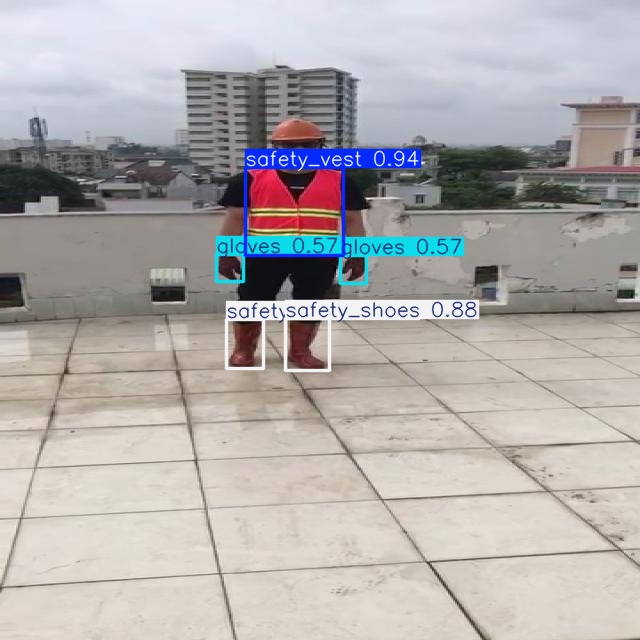

In [ ]:
from ultralytics import YOLO
from pathlib import Path
from IPython.display import display, Image

# Carica modello
model = YOLO("/content/runs/detect/DPI3_gpu_run/weights/best.pt")

REQUIRED_DPI = {"safety_vest", "gloves", "safety_shoes"}

def check_and_show(image_path, conf=0.25):
    results = model.predict(source=image_path, conf=conf, save=True, verbose=False)
    r = results[0]

    detected = set()
    for cls_id in r.boxes.cls.tolist():
        detected.add(r.names[int(cls_id)])

    missing = REQUIRED_DPI - detected
    compliant = len(missing) == 0

    print("RILEVATI:", detected)
    print("MANCANTI:", missing)
    print("CONFORME:", compliant)

    # Mostra immagine salvata
    display(Image(filename=r.save_dir + "/" + Path(image_path).name))

# prova su un'immagine di test
sample_img = next(Path("Construction-PPE-1_DPI3/test/images").glob("*"))
check_and_show(str(sample_img))

In [ ]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 63.8 MB/s eta 0:00:00


In [ ]:
!ls

sample_data


In [ ]:
!ls /content

best.pt  sample_data


In [ ]:
!ls -lh /content | grep best.pt

-rw-r--r-- 1 root root 6.0M Feb  5 17:17 best.pt


In [ ]:
!pip install -q ultralytics

from ultralytics import YOLO

model = YOLO("/content/best.pt")
print("✅ Modello caricato correttamente")

✅ Modello caricato correttamente


In [ ]:
!pip install -q roboflow ultralytics
!nvidia-smi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 122.1 MB/s eta 0:00:00
Thu Feb  5 17:22:07 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|========================

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="ZhKWCwI8rz9309wg03nk")
project = rf.workspace("andrea-marazzina").project("construction-ppe-rdhzo-fnopv")
version = project.version(1)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Construction-PPE-1 in yolov8:: 100%|██████████| 17702/17702 [00:02<00:00, 5904.24it/s]


In [ ]:
!ls

best.pt  Construction-PPE-1  sample_data


In [ ]:
import os
import shutil
from pathlib import Path

src_root = Path("Construction-PPE-1")
dst_root = Path("Construction-PPE-1_DPI3")
splits = ["train", "valid", "test"]

# mapping classi originali -> nuove classi
# 0 safety_vest: (4 Safety Vest, 15 vest)
# 1 gloves: (0 Gloves, 7 gloves)
# 2 safety_shoes: (3 Safety Boot, 5 boots)
keep_classes = {
    4: 0,    # Safety Vest
    15: 0,   # vest
    0: 1,    # Gloves
    7: 1,    # gloves
    3: 2,    # Safety Boot
    5: 2     # boots
}

def find_image_file(img_dir: Path, stem: str):
    for ext in [".jpg", ".jpeg", ".png", ".webp"]:
        p = img_dir / f"{stem}{ext}"
        if p.exists():
            return p
    return None

# reset output
if dst_root.exists():
    shutil.rmtree(dst_root)
dst_root.mkdir(parents=True, exist_ok=True)

stats = {s: {"kept_images": 0, "kept_labels": 0} for s in splits}

for split in splits:
    src_img_dir = src_root / split / "images"
    src_lbl_dir = src_root / split / "labels"

    dst_img_dir = dst_root / split / "images"
    dst_lbl_dir = dst_root / split / "labels"
    dst_img_dir.mkdir(parents=True, exist_ok=True)
    dst_lbl_dir.mkdir(parents=True, exist_ok=True)

    for label_path in src_lbl_dir.glob("*.txt"):
        stem = label_path.stem
        new_lines = []

        lines = label_path.read_text().strip().splitlines()
        for line in lines:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            old_cls = int(float(parts[0]))
            if old_cls in keep_classes:
                parts[0] = str(keep_classes[old_cls])
                new_lines.append(" ".join(parts))

        if new_lines:
            img_path = find_image_file(src_img_dir, stem)
            if img_path is None:
                continue

            shutil.copy(img_path, dst_img_dir / img_path.name)
            (dst_lbl_dir / f"{stem}.txt").write_text("\n".join(new_lines))

            stats[split]["kept_images"] += 1
            stats[split]["kept_labels"] += len(new_lines)

print("✅ Dataset DPI3 creato!")
for split in splits:
    print(f"- {split}: images={stats[split]['kept_images']} labels={stats[split]['kept_labels']}")

data_yaml = f"""path: {dst_root}
train: train/images
val: valid/images
test: test/images

names:
  0: safety_vest
  1: gloves
  2: safety_shoes
"""
(dst_root / "data.yaml").write_text(data_yaml)
print("✅ Creato anche:", dst_root / "data.yaml")

✅ Dataset DPI3 creato!
- train: images=7016 labels=23445
- valid: images=784 labels=2801
- test: images=354 labels=1210
✅ Creato anche: Construction-PPE-1_DPI3/data.yaml


In [ ]:
!ls Construction-PPE-1_DPI3

data.yaml  test  train	valid


In [ ]:
from ultralytics import YOLO

model = YOLO("/content/best.pt")

metrics = model.val(
    data="Construction-PPE-1_DPI3/data.yaml",
    split="test",
    conf=0.25,
    iou=0.5,
    plots=True
)

print("Class order:", model.names)
print("mAP@50-95 per classe:", metrics.box.maps)
print("Precision media:", metrics.box.mp)
print("Recall medio:", metrics.box.mr)

Ultralytics 8.4.12 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 73 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1714.0±421.7 MB/s, size: 58.4 KB)
val: Scanning /content/Construction-PPE-1_DPI3/test/labels... 354 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 354/354 2.0Kit/s 0.2s
val: New cache created: /content/Construction-PPE-1_DPI3/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 23/23 3.9it/s 5.9s
                   all        354       1210       0.82      0.921      0.839      0.674
           safety_vest        335        502       0.96      0.875      0.939      0.812
                gloves        130        238      0.537      0.908      0.589      0.412
          safety_shoes        232        470      0.962      0.982       0.99        0.8
Speed: 2.2ms preprocess, 4.8ms inference, 0.0ms loss, 1.

In [ ]:
model.predict(
    source="Construction-PPE-1_DPI3/test/images",
    save=True,
    conf=0.25,
    name="DPI3_test_preds"
)


image 1/354 /content/Construction-PPE-1_DPI3/test/images/00000009_jpg.rf.f28f4bf1694695de0592898a09a7a536.jpg: 384x640 1 safety_vest, 37.9ms
image 2/354 /content/Construction-PPE-1_DPI3/test/images/00000028_jpg.rf.efea3f07920d1141570facc74bcc109f.jpg: 384x640 10 safety_vests, 5.8ms
image 3/354 /content/Construction-PPE-1_DPI3/test/images/00000038_jpg.rf.ad04ed97115675256e2c2b98e95facc9.jpg: 384x640 1 gloves, 5.4ms
image 4/354 /content/Construction-PPE-1_DPI3/test/images/00000053_jpg.rf.a86015752323ab1cd43f0a7f0bceb948.jpg: 384x640 6 safety_vests, 5.5ms
image 5/354 /content/Construction-PPE-1_DPI3/test/images/00000126_jpg.rf.bfc586bd6da5cb78f4f358c0777497f9.jpg: 384x640 5 safety_vests, 5.4ms
image 6/354 /content/Construction-PPE-1_DPI3/test/images/00000204_jpg.rf.c3399c4b85f5d4d0445e5a71e838fae2.jpg: 384x640 4 safety_vests, 5.5ms
image 7/354 /content/Construction-PPE-1_DPI3/test/images/00000216_jpg.rf.753f4d842a735efa4c3178299296c43f.jpg: 384x640 (no detections), 5.4ms
image 8/354 /con

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'safety_vest', 1: 'gloves', 2: 'safety_shoes'}
 obb: None
 orig_img: array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [109, 134, 206],
         [112, 137, 209],
         [105, 130, 202]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [108, 133, 205],
         [110, 135, 207],
         [105, 130, 202]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [108, 136, 207],
         [110, 138, 209],
         [106, 134, 205]],
 
        ...,
 
        [[ 83,  85,  96],
         [ 84,  86,  97],
         [ 83,  85,  96],
         ...,
         [141, 124, 168],
         [141, 124, 168],
         [141, 124, 168]],
 
        [[ 84,  86,  97],
         [ 86,  88,  99],
         [ 85,  87,  

In [ ]:
!ls runs/detect

DPI3_test_preds  val


In [ ]:
!nvidia-smi
!pip install -q ultralytics roboflow

Fri Feb  6 17:36:08 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from ultralytics import YOLO
model = YOLO("/content/best.pt")
print("✅ Modello caricato")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ Modello caricato


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="ZhKWCwI8rz9309wg03nk")
project = rf.workspace("andrea-marazzina").project("construction-ppe-rdhzo-fnopv")
version = project.version(1)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Construction-PPE-1 in yolov8:: 100%|██████████| 17702/17702 [00:02<00:00, 6241.11it/s]


In [ ]:
import shutil
from pathlib import Path

src_root = Path("Construction-PPE-1")
dst_root = Path("Construction-PPE-1_DPI3")
splits = ["train", "valid", "test"]

keep_classes = {
    4: 0,   # Safety Vest
    15: 0,  # vest
    0: 1,   # Gloves
    7: 1,   # gloves
    3: 2,   # Safety Boot
    5: 2    # boots
}

def find_image_file(img_dir: Path, stem: str):
    for ext in [".jpg", ".jpeg", ".png", ".webp"]:
        p = img_dir / f"{stem}{ext}"
        if p.exists():
            return p
    return None

if dst_root.exists():
    shutil.rmtree(dst_root)
dst_root.mkdir(parents=True, exist_ok=True)

for split in splits:
    (dst_root / split / "images").mkdir(parents=True, exist_ok=True)
    (dst_root / split / "labels").mkdir(parents=True, exist_ok=True)

    src_img_dir = src_root / split / "images"
    src_lbl_dir = src_root / split / "labels"
    dst_img_dir = dst_root / split / "images"
    dst_lbl_dir = dst_root / split / "labels"

    for label_path in src_lbl_dir.glob("*.txt"):
        stem = label_path.stem
        new_lines = []
        for line in label_path.read_text().strip().splitlines():
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            old_cls = int(float(parts[0]))
            if old_cls in keep_classes:
                parts[0] = str(keep_classes[old_cls])
                new_lines.append(" ".join(parts))

        if new_lines:
            img_path = find_image_file(src_img_dir, stem)
            if img_path is None:
                continue
            shutil.copy(img_path, dst_img_dir / img_path.name)
            (dst_lbl_dir / f"{stem}.txt").write_text("\n".join(new_lines))

data_yaml = f"""path: {dst_root}
train: train/images
val: valid/images
test: test/images

names:
  0: safety_vest
  1: gloves
  2: safety_shoes
"""
(dst_root / "data.yaml").write_text(data_yaml)
print("✅ DPI3 pronto:", dst_root)

✅ DPI3 pronto: Construction-PPE-1_DPI3


In [ ]:
import json

CLASS_MAP = {0: "safety_vest", 1: "gloves", 2: "safety_shoes"}
REQUIRED = {"safety_vest", "gloves", "safety_shoes"}

def compliance_engine(image_path, conf=0.25):
    r = model.predict(source=image_path, conf=conf, verbose=False)[0]

    detected = set()
    conf_by_class = {}

    if r.boxes is not None and len(r.boxes) > 0:
        for cls_id, score in zip(r.boxes.cls.tolist(), r.boxes.conf.tolist()):
            cls_name = CLASS_MAP[int(cls_id)]
            detected.add(cls_name)
            conf_by_class[cls_name] = max(conf_by_class.get(cls_name, 0.0), float(score))

    missing = sorted(list(REQUIRED - detected))
    detected = sorted(list(detected))

    if len(missing) == 0:
        status = "CONFORME"
    elif len(missing) == 1:
        status = "PARZIALMENTE_CONFORME"
    else:
        status = "NON_CONFORME"

    return {
        "image": image_path,
        "status": status,
        "detected": detected,
        "missing": missing,
        "confidence_by_class": conf_by_class
    }

In [ ]:
from pathlib import Path
sample_img = next(Path("Construction-PPE-1_DPI3/test/images").glob("*"))

out = compliance_engine(str(sample_img), conf=0.25)
print(json.dumps(out, indent=2))

{
  "image": "Construction-PPE-1_DPI3/test/images/IMG-20230805-WA0021_jpg.rf.7241eee372b0c42cba7995a5b2d23bb0.jpg",
  "status": "NON_CONFORME",
  "detected": [
    "safety_vest"
  ],
  "missing": [
    "gloves",
    "safety_shoes"
  ],
  "confidence_by_class": {
    "safety_vest": 0.7951398491859436
  }
}


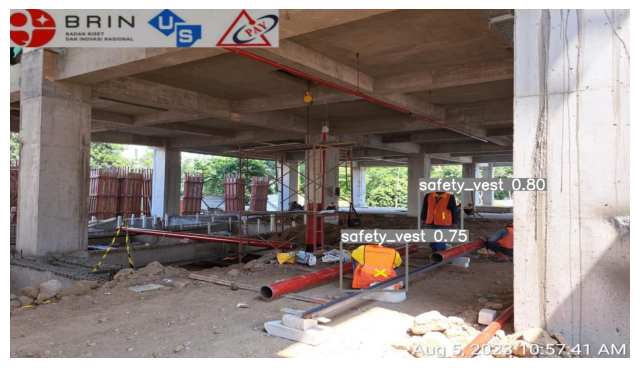

In [ ]:
from ultralytics.utils.plotting import Annotator
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def show_prediction(image_path, conf=0.25):
    r = model.predict(source=image_path, conf=conf, verbose=False)[0]
    img = Image.open(image_path).convert("RGB")
    img_np = np.array(img)

    annotator = Annotator(img_np.copy())
    if r.boxes is not None and len(r.boxes) > 0:
        for box, cls_id, score in zip(r.boxes.xyxy, r.boxes.cls, r.boxes.conf):
            cls_name = CLASS_MAP[int(cls_id)]
            label = f"{cls_name} {float(score):.2f}"
            annotator.box_label(box.tolist(), label)
    out_img = annotator.result()

    plt.figure(figsize=(8,6))
    plt.imshow(out_img)
    plt.axis("off")
    plt.show()

show_prediction(str(sample_img), conf=0.25)

In [ ]:
from collections import Counter
from pathlib import Path
import pandas as pd

def run_batch_kpi(n=200, conf=0.25):
    imgs = list(Path("Construction-PPE-1_DPI3/test/images").glob("*"))[:n]

    status_counter = Counter()
    missing_counter = Counter()
    rows = []

    for img in imgs:
        out = compliance_engine(str(img), conf=conf)
        status_counter[out["status"]] += 1
        for m in out["missing"]:
            missing_counter[m] += 1

        rows.append({
            "image": out["image"],
            "status": out["status"],
            "missing": ",".join(out["missing"]),
            "detected": ",".join(out["detected"])
        })

    df = pd.DataFrame(rows)
    return df, status_counter, missing_counter

df_kpi, status_c, missing_c = run_batch_kpi(n=200, conf=0.25)
print("Status counts:", status_c)
print("Missing counts:", missing_c)
df_kpi.head()

Status counts: Counter({'CONFORME': 112, 'NON_CONFORME': 73, 'PARZIALMENTE_CONFORME': 15})
Missing counts: Counter({'safety_shoes': 75, 'gloves': 72, 'safety_vest': 15})


,image,status,missing,detected
0,Construction-PPE-1_DPI3/test/images/IMG-202308...,NON_CONFORME,"gloves,safety_shoes",safety_vest
1,Construction-PPE-1_DPI3/test/images/AightSird0...,NON_CONFORME,"gloves,safety_shoes",safety_vest
2,Construction-PPE-1_DPI3/test/images/Tan0639639...,NON_CONFORME,"gloves,safety_shoes",safety_vest
3,Construction-PPE-1_DPI3/test/images/Video1_226...,CONFORME,,"gloves,safety_shoes,safety_vest"
4,Construction-PPE-1_DPI3/test/images/Aitin3205_...,NON_CONFORME,"gloves,safety_shoes",safety_vest


In [ ]:
df_kpi.to_csv("kpi_report_testset.csv", index=False)
print("✅ Salvato: kpi_report_testset.csv")

✅ Salvato: kpi_report_testset.csv


In [ ]:
TRAINING_TIPS = {
    "safety_vest": "Indossa il gilet alta visibilità e assicurati che sia chiuso e ben visibile.",
    "gloves": "Indossa guanti adatti alla mansione e verifica che coprano interamente le mani.",
    "safety_shoes": "Indossa scarpe antinfortunistiche (puntale/antiscivolo) prima di entrare in area operativa."
}

def compliance_engine_with_training(image_path, conf=0.25):
    out = compliance_engine(image_path, conf=conf)
    if out["status"] != "CONFORME":
        out["next_action"] = [TRAINING_TIPS[m] for m in out["missing"]]
    else:
        out["next_action"] = ["Accesso consentito. Grazie per la conformità ai DPI."]
    return out

print(compliance_engine_with_training(str(sample_img), conf=0.25))

{'image': 'Construction-PPE-1_DPI3/test/images/IMG-20230805-WA0021_jpg.rf.7241eee372b0c42cba7995a5b2d23bb0.jpg', 'status': 'NON_CONFORME', 'detected': ['safety_vest'], 'missing': ['gloves', 'safety_shoes'], 'confidence_by_class': {'safety_vest': 0.7951398491859436}, 'next_action': ['Indossa guanti adatti alla mansione e verifica che coprano interamente le mani.', 'Indossa scarpe antinfortunistiche (puntale/antiscivolo) prima di entrare in area operativa.']}


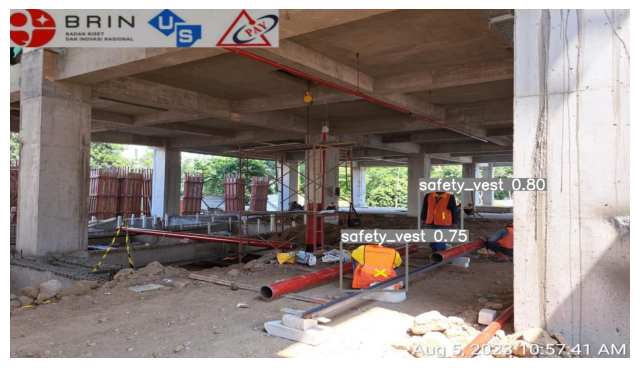

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from ultralytics.utils.plotting import Annotator

def show_prediction(image_path, conf=0.25):
    r = model.predict(source=image_path, conf=conf, verbose=False)[0]
    img = Image.open(image_path).convert("RGB")
    img_np = np.array(img)

    annotator = Annotator(img_np.copy())
    if r.boxes is not None and len(r.boxes) > 0:
        for box, cls_id, score in zip(r.boxes.xyxy, r.boxes.cls, r.boxes.conf):
            cls_name = CLASS_MAP[int(cls_id)]
            label = f"{cls_name} {float(score):.2f}"
            annotator.box_label(box.tolist(), label)

    out_img = annotator.result()
    plt.figure(figsize=(8,6))
    plt.imshow(out_img)
    plt.axis("off")
    plt.show()

show_prediction(str(sample_img), conf=0.25)

In [ ]:
from collections import Counter
from pathlib import Path
import pandas as pd

def run_batch_kpi(n=200, conf=0.25):
    imgs = list(Path("Construction-PPE-1_DPI3/test/images").glob("*"))
    imgs = imgs[:min(n, len(imgs))]

    status_counter = Counter()
    missing_counter = Counter()
    rows = []

    for img in imgs:
        out = compliance_engine(str(img), conf=conf)
        status_counter[out["status"]] += 1
        for m in out["missing"]:
            missing_counter[m] += 1

        rows.append({
            "image": out["image"],
            "status": out["status"],
            "detected": ",".join(out["detected"]),
            "missing": ",".join(out["missing"])
        })

    df = pd.DataFrame(rows)
    return df, status_counter, missing_counter

df_kpi, status_c, missing_c = run_batch_kpi(n=200, conf=0.25)

print("✅ KPI status:", status_c)
print("✅ DPI mancanti (conteggio):", missing_c)
df_kpi.head(10)

✅ KPI status: Counter({'CONFORME': 112, 'NON_CONFORME': 73, 'PARZIALMENTE_CONFORME': 15})
✅ DPI mancanti (conteggio): Counter({'safety_shoes': 75, 'gloves': 72, 'safety_vest': 15})


,image,status,detected,missing
0,Construction-PPE-1_DPI3/test/images/IMG-202308...,NON_CONFORME,safety_vest,"gloves,safety_shoes"
1,Construction-PPE-1_DPI3/test/images/AightSird0...,NON_CONFORME,safety_vest,"gloves,safety_shoes"
2,Construction-PPE-1_DPI3/test/images/Tan0639639...,NON_CONFORME,safety_vest,"gloves,safety_shoes"
3,Construction-PPE-1_DPI3/test/images/Video1_226...,CONFORME,"gloves,safety_shoes,safety_vest",
4,Construction-PPE-1_DPI3/test/images/Aitin3205_...,NON_CONFORME,safety_vest,"gloves,safety_shoes"
5,Construction-PPE-1_DPI3/test/images/Video3_141...,CONFORME,"gloves,safety_shoes,safety_vest",
6,Construction-PPE-1_DPI3/test/images/Video4_231...,CONFORME,"gloves,safety_shoes,safety_vest",
7,Construction-PPE-1_DPI3/test/images/images-202...,NON_CONFORME,gloves,"safety_shoes,safety_vest"
8,Construction-PPE-1_DPI3/test/images/ppe_0925_j...,NON_CONFORME,safety_shoes,"gloves,safety_vest"
9,Construction-PPE-1_DPI3/test/images/Video3_273...,CONFORME,"gloves,safety_shoes,safety_vest",


In [ ]:
df_kpi.to_csv("kpi_report_testset.csv", index=False)
print("✅ Salvato: /content/kpi_report_testset.csv")

✅ Salvato: /content/kpi_report_testset.csv


In [ ]:
TRAINING_TIPS = {
    "safety_vest": "Indossa il gilet ad alta visibilità e assicurati che sia ben visibile e correttamente chiuso.",
    "gloves": "Indossa i guanti DPI prima di entrare in area operativa (verifica taglia e aderenza).",
    "safety_shoes": "Indossa scarpe antinfortunistiche con puntale e suola idonea (antiscivolo)."
}

def compliance_engine_with_training(image_path, conf=0.25):
    out = compliance_engine(image_path, conf=conf)
    if out["status"] != "CONFORME":
        out["next_action"] = [TRAINING_TIPS[m] for m in out["missing"]]
    else:
        out["next_action"] = ["Accesso consentito. Grazie per la conformità ai DPI."]
    return out

print(compliance_engine_with_training(str(sample_img), conf=0.25))

{'image': 'Construction-PPE-1_DPI3/test/images/IMG-20230805-WA0021_jpg.rf.7241eee372b0c42cba7995a5b2d23bb0.jpg', 'status': 'NON_CONFORME', 'detected': ['safety_vest'], 'missing': ['gloves', 'safety_shoes'], 'confidence_by_class': {'safety_vest': 0.7951398491859436}, 'next_action': ['Indossa i guanti DPI prima di entrare in area operativa (verifica taglia e aderenza).', 'Indossa scarpe antinfortunistiche con puntale e suola idonea (antiscivolo).']}


In [ ]:
df_kpi, status_c, missing_c = run_batch_kpi(n=200, conf=0.25)

print("KPI Status:", status_c)
print("DPI più spesso mancanti:", missing_c)

df_kpi.head()

KPI Status: Counter({'CONFORME': 112, 'NON_CONFORME': 73, 'PARZIALMENTE_CONFORME': 15})
DPI più spesso mancanti: Counter({'safety_shoes': 75, 'gloves': 72, 'safety_vest': 15})


,image,status,detected,missing
0,Construction-PPE-1_DPI3/test/images/IMG-202308...,NON_CONFORME,safety_vest,"gloves,safety_shoes"
1,Construction-PPE-1_DPI3/test/images/AightSird0...,NON_CONFORME,safety_vest,"gloves,safety_shoes"
2,Construction-PPE-1_DPI3/test/images/Tan0639639...,NON_CONFORME,safety_vest,"gloves,safety_shoes"
3,Construction-PPE-1_DPI3/test/images/Video1_226...,CONFORME,"gloves,safety_shoes,safety_vest",
4,Construction-PPE-1_DPI3/test/images/Aitin3205_...,NON_CONFORME,safety_vest,"gloves,safety_shoes"


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 44.6 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
model = YOLO("best.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
